##### =========================================================================
#### PART 0: Environment Setup and Package Installation
##### =========================================================================
#### Install all necessary Python packages
##### =========================================================================

In [1]:
!pip install scanpy squidpy numpy pandas matplotlib seaborn scikit-learn
!pip3 install louvain igraph leidenalg
!pip install gseapy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of ome-zarr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/

#### =======================================================================
#### PART 1: Data Loading, Preprocessing, and Quality Control
#### 1. Import Required Libraries
#### =======================================================================

In [2]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, Birch
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import os

# Create a folder to store the generated images.
if not os.path.exists('figures'):
    os.makedirs('figures')

/usr/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.12/dist-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


##### 2.Load the example dataset
#####Use the Visium H&E stained mouse brain dataset provided by Squidpy.

In [3]:
adata = sq.datasets.visium_hne_adata()
print(f"Original data dimensions: {adata.shape}")
print("\nObservation (spots) metadata (first 5 rows):")
print(adata.obs.head())
print("\nVariable (genes) metadata (first 5 rows):")
print(adata.var.head())

  0%|          | 0.00/314M [00:00<?, ?B/s]

Original data dimensions: (2688, 18078)

Observation (spots) metadata (first 5 rows):
                    in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAAGTATCTCCCA-1          1         50        102               4928   
AAACAATCTACTAGCA-1          1          3         43               3448   
AAACACCAATAACTGC-1          1         59         19               6022   
AAACAGAGCGACTCCT-1          1         14         94               4311   
AAACCGGGTAGGTACC-1          1         42         28               5787   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAAGTATCTCCCA-1                 8.502891       19340.0            9.869983   
AAACAATCTACTAGCA-1                 8.145840       13750.0            9.528867   
AAACACCAATAACTGC-1                 8.703341       32710.0           10.395467   
AAACAGAGCGACTCCT-1                 8.369157       15909.0            9.674704   
AAACCGGGTAGGTACC-1                 8.663542       31856.0       

##### 3.Visualize Ground Truth
#####Use the 'cluster' column as the true labels to plot the spatial distribution map.
#####This will generate an image showing the actual positions of different cell clusters on the tissue sample.


Generating Ground Truth image...


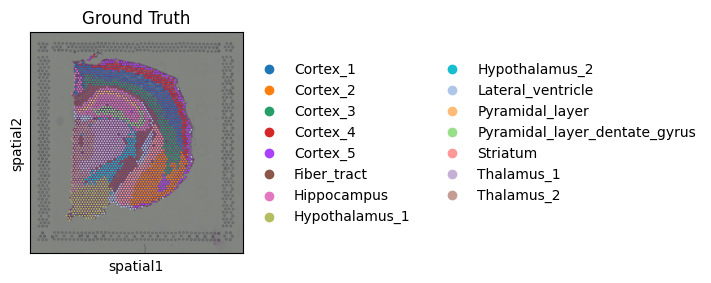

In [4]:
print("\nGenerating Ground Truth image...")
sq.pl.spatial_scatter(
    adata,
    color="cluster",      # Specify the 'cluster' column as the color label
    title="Ground Truth", # Set the image title
    figsize=(7, 7),       # Set the image size for clear display
    save="_ground_truth_spatial.png"
)
plt.show() # Display the image in Colab

##### 4. Data Quality Control (QC) and Gene Expression Statistical Analysis

In [5]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
print(f"\nData dimensions before filtering: {adata.shape}")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print(f"Data dimensions after filtering: {adata.shape}")


Data dimensions before filtering: (2688, 18078)
Data dimensions after filtering: (2688, 18078)


##### Gene Expression Statistical Analysis (Violin Plot)


=== Gene Expression Statistical Analysis ===


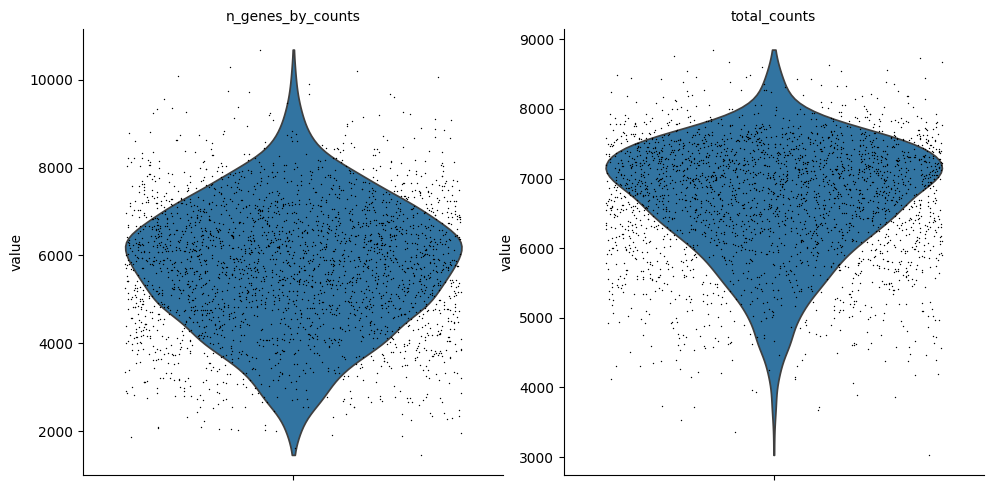

In [6]:
print("\n=== Gene Expression Statistical Analysis ===")
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True, save="_qc_violin_plots.png")
plt.show() # Display the image in Colab

##### ==============================================================================
##### Spatial Autocorrelation Analysis
##### ==============================================================================


Spatial Autocorrelation Analysis)


  0%|          | 0/100 [00:00<?, ?/s]


--- Moran's I Analysis Results (Top 10 Genes with Highest Positive Correlation) ---
                I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
Nrgn     0.874753        0.0  0.000131         0.0  0.009901  0.000332   
Mbp      0.868723        0.0  0.000131         0.0  0.009901  0.000320   
Camk2n1  0.866542        0.0  0.000131         0.0  0.009901  0.000360   
Slc17a7  0.861761        0.0  0.000131         0.0  0.009901  0.000346   
Ttr      0.841986        0.0  0.000131         0.0  0.009901  0.000317   
Prkcd    0.823550        0.0  0.000131         0.0  0.009901  0.000281   
Pmch     0.818155        0.0  0.000131         0.0  0.009901  0.000319   
Fth1     0.811259        0.0  0.000131         0.0  0.009901  0.000278   
Mobp     0.810947        0.0  0.000131         0.0  0.009901  0.000336   
Cck      0.810927        0.0  0.000131         0.0  0.009901  0.000262   

         pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
Nrgn                  0.0           

/tmp/ipython-input-2205565758.py:27: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


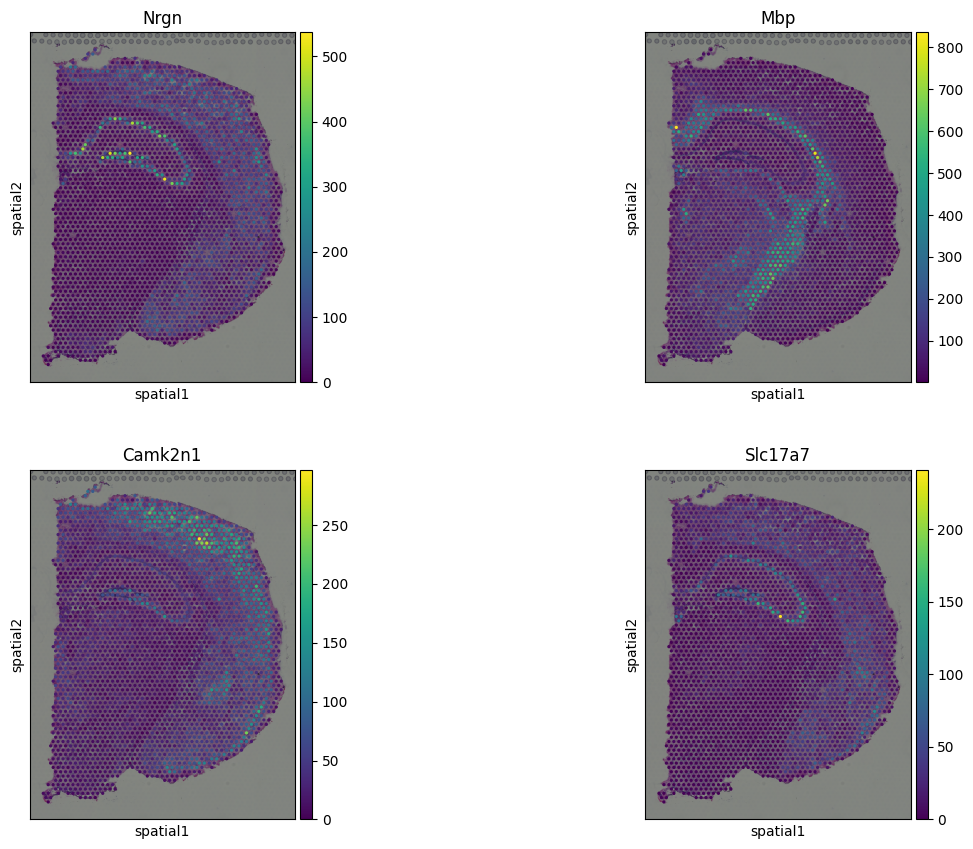

In [7]:
import matplotlib.pyplot as plt

print("\nSpatial Autocorrelation Analysis)")

# First, calculate the spatial neighbors graph
# This defines which spots are adjacent based on their physical distances
sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6)

# Calculate Moran's I values for all highly variable genes
# n_perms specifies the number of random permutations used to calculate the p-value; increasing this value improves accuracy but takes longer to compute
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    genes=adata.var_names,
    n_perms=100,
    n_jobs=1,
)

# Examine the Moran's I results and identify the genes with the highest spatial autocorrelation
moran_i_results = adata.uns["moranI"]
print("\n--- Moran's I Analysis Results (Top 10 Genes with Highest Positive Correlation) ---")
print(moran_i_results.head(10))

# Visualize the spatial expression patterns of the genes with the highest Moran's I values
top_spatial_genes = moran_i_results.index[:4]
print(f"\nVisualizing the spatial expression of genes: {list(top_spatial_genes)}...")
sc.pl.spatial(
    adata,
    color=top_spatial_genes,
    ncols=2,
    cmap="viridis",
    save="_top_spatial_genes.png"
)
plt.show()

##### 5. Data Normalization, Feature Selection, and Dimensionality Reduction

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
print(f"\nData dimensions after selecting highly variable genes: {adata.shape}")


Data dimensions after selecting highly variable genes: (2688, 3363)


##### PCA

In [9]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_pca/__init__.py:385: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


##### ==============================================================================
##### PART 2: Comparative Analysis of Multiple Clustering Methods
##### ==============================================================================

##### a. Leiden Clustering

In [10]:
print("\n--- Performing Leiden Clustering ---")
sc.tl.leiden(adata, resolution=0.5, key_added="leiden")


--- Performing Leiden Clustering ---


/tmp/ipython-input-921513034.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added="leiden")


##### b. K-Means Clustering

In [11]:
kmeans = KMeans(n_clusters=len(adata.obs['cluster'].unique()), random_state=0, n_init=10).fit(adata.obsm['X_pca']) # n_init=10 is the new default
adata.obs['kmeans'] = kmeans.labels_.astype(str)

##### c. Louvain Clustering

In [12]:
print("--- Performing Louvain Clustering ---")
sc.tl.louvain(adata, key_added="louvain")

--- Performing Louvain Clustering ---


##### d. BIRCH Clustering

In [13]:
print("--- Performing BIRCH Clustering ---")
birch = Birch(n_clusters=len(adata.obs['cluster'].unique())).fit(adata.obsm['X_pca'])
adata.obs['birch'] = birch.labels_.astype(str)

print("\n=== Multiple clustering methods completed. ===")

--- Performing BIRCH Clustering ---

=== Multiple clustering methods completed. ===


##### ==============================================================================
##### PART 3: Data Visualization and Clustering Performance Evaluation
##### ==============================================================================

In [14]:
keys_to_delete = ['leiden_colors', 'kmeans_colors', 'louvain_colors', 'birch_colors']
for key in keys_to_delete:
    if key in adata.uns:
        del adata.uns[key]

#### 1. Visualization Comparison


--- Visualization Comparison ---


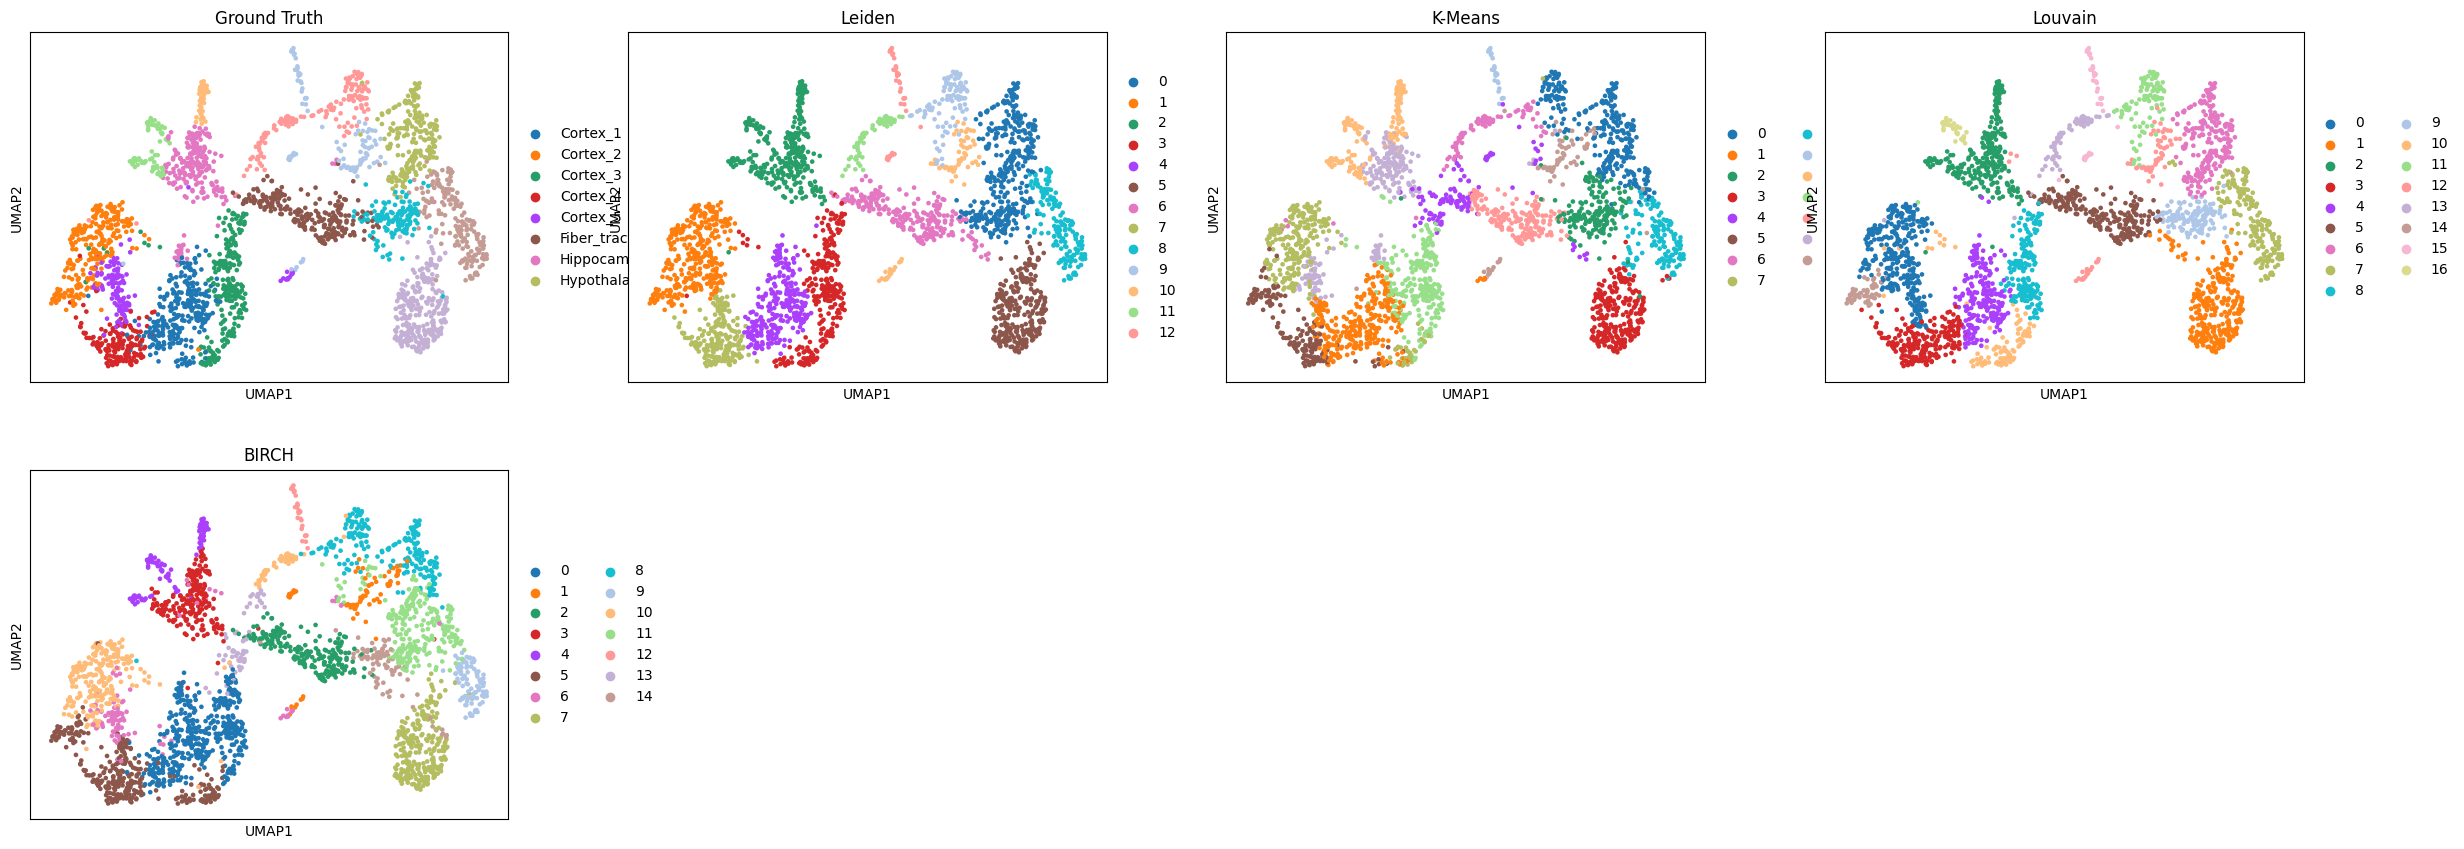

In [15]:
print("\n--- Visualization Comparison ---")
sc.pl.umap(adata, color=['cluster', 'leiden', 'kmeans', 'louvain', 'birch'],
           title=['Ground Truth', 'Leiden', 'K-Means', 'Louvain', 'BIRCH'],
           save="_umap_comparison.png")
plt.show()



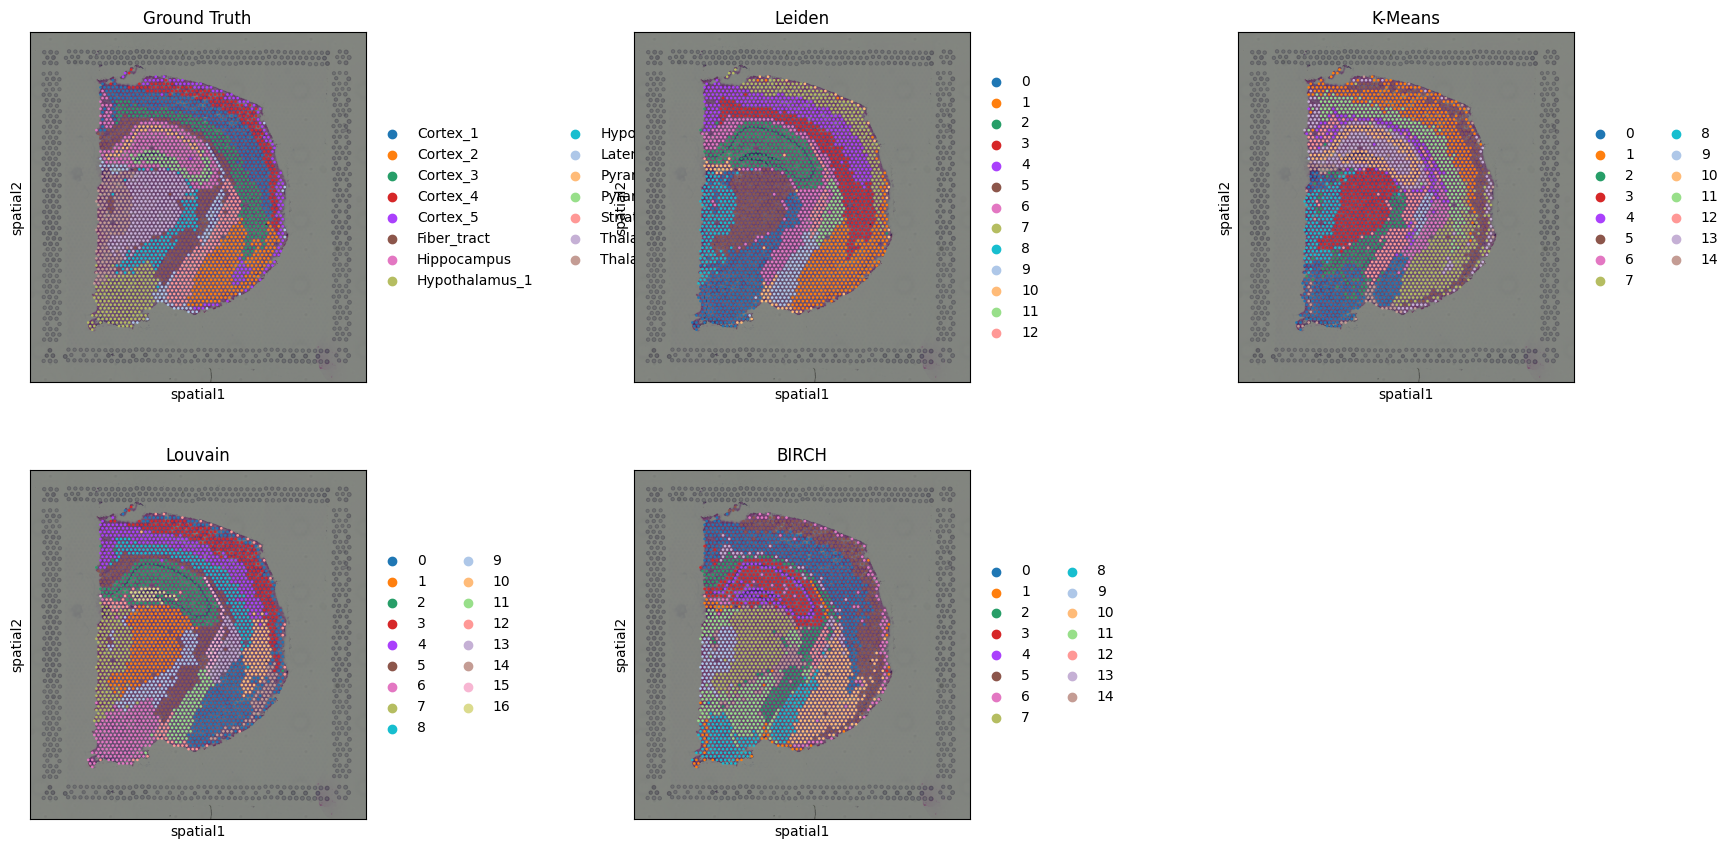

In [16]:
sq.pl.spatial_scatter(adata, color=['cluster', 'leiden', 'kmeans', 'louvain', 'birch'],
                      title=['Ground Truth', 'Leiden', 'K-Means', 'Louvain', 'BIRCH'],
                      save="_spatial_comparison.png", ncols=3)
plt.show()

#### 2. Quantitative Evaluation Comparison

In [17]:
print("\n--- Quantitative Evaluation Comparison ---")
ground_truth_labels = adata.obs['cluster']
leiden_labels = adata.obs['leiden']
kmeans_labels = adata.obs['kmeans']
louvain_labels = adata.obs['louvain']
birch_labels = adata.obs['birch']


--- Quantitative Evaluation Comparison ---


In [18]:
# Calculate ARI (Adjusted Rand Index)
ari_leiden = adjusted_rand_score(ground_truth_labels, leiden_labels)
ari_kmeans = adjusted_rand_score(ground_truth_labels, kmeans_labels)
ari_louvain = adjusted_rand_score(ground_truth_labels, louvain_labels)
ari_birch = adjusted_rand_score(ground_truth_labels, birch_labels)

In [19]:
# Calculate NMI (Normalized Mutual Information)
nmi_leiden = normalized_mutual_info_score(ground_truth_labels, leiden_labels)
nmi_kmeans = normalized_mutual_info_score(ground_truth_labels, kmeans_labels)
nmi_louvain = normalized_mutual_info_score(ground_truth_labels, louvain_labels)
nmi_birch = normalized_mutual_info_score(ground_truth_labels, birch_labels)

In [20]:
# Create a DataFrame for the evaluation results
evaluation_df = pd.DataFrame({
    'Method': ['Leiden', 'K-Means', 'Louvain', 'BIRCH'],
    'ARI': [ari_leiden, ari_kmeans, ari_louvain, ari_birch],
    'NMI': [nmi_leiden, nmi_kmeans, nmi_louvain, nmi_birch]
})

print("\nClustering Performance Evaluation Results:")
print(evaluation_df)


Clustering Performance Evaluation Results:
    Method       ARI       NMI
0   Leiden  0.725646  0.824639
1  K-Means  0.573430  0.720149
2  Louvain  0.699064  0.808694
3    BIRCH  0.557828  0.720065


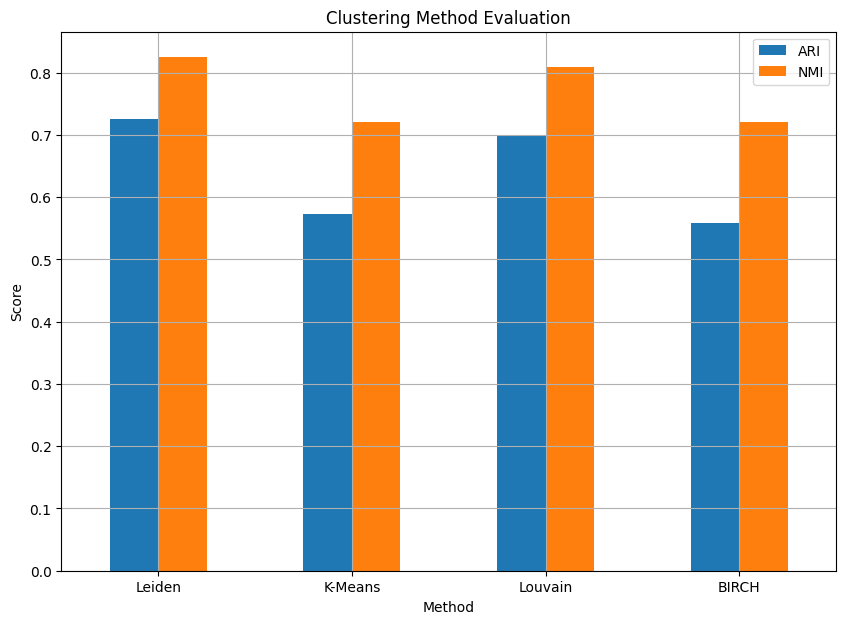

In [21]:
# Plot a bar chart of the evaluation metrics
evaluation_df.plot(x='Method', y=['ARI', 'NMI'], kind='bar', figsize=(10, 7), grid=True)
plt.title('Clustering Method Evaluation')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.savefig('figures/evaluation_barplot.png')
plt.show()